In [276]:
# Predict whether a person makes over 50K per year or not from classic adult dataset using XGBoost.
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, log_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import accuracy_score
%matplotlib inline
import seaborn as sns
sns.set(font_scale = 1.5) 
train_set = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', header = None)
test_set = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test', skiprows = 1, header = None)
col_labels = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation','relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'wage_class']
train_set.columns = col_labels
test_set.columns = col_labels

In [277]:
print(train_set.head())
print(test_set.head())

   age          workclass  fnlwgt   education  education_num  \
0   39          State-gov   77516   Bachelors             13   
1   50   Self-emp-not-inc   83311   Bachelors             13   
2   38            Private  215646     HS-grad              9   
3   53            Private  234721        11th              7   
4   28            Private  338409   Bachelors             13   

        marital_status          occupation    relationship    race      sex  \
0        Never-married        Adm-clerical   Not-in-family   White     Male   
1   Married-civ-spouse     Exec-managerial         Husband   White     Male   
2             Divorced   Handlers-cleaners   Not-in-family   White     Male   
3   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
4   Married-civ-spouse      Prof-specialty            Wife   Black   Female   

   capital_gain  capital_loss  hours_per_week  native_country wage_class  
0          2174             0              40   United-States    

In [ ]:
# Data Exploration

In [278]:
# Replacing the '?' mark symbol with NaN values first and then dropping them
train_set = train_set.replace(' ?', np.nan).dropna()
train_set.shape 

(30162, 15)

In [279]:
# Replacing the '?' mark symbol with NaN values first and then dropping them
test_set = test_set.replace(' ?', np.nan).dropna() 
test_set.shape 

(15060, 15)

In [280]:
test_set['wage_class'] = test_set.wage_class.replace({' <=50K.': ' <=50K', ' >50K.':' >50K'})

In [281]:
test_set['wage_class'].unique()

array([' <=50K', ' >50K'], dtype=object)

In [282]:
train_set['wage_class'] = train_set.wage_class.replace({' <=50K.': ' <=50K', ' >50K.':' >50K'})

In [283]:
train_set['wage_class'].unique()

array([' <=50K', ' >50K'], dtype=object)

In [284]:
# Appending into a single dataset to handle the columns with categorical strings
dataset = pd.concat([train_set, test_set], axis = 0)

In [285]:
# Exploring the native_country column
dataset['native_country'].value_counts(normalize=True)

 United-States                 0.913095
 Mexico                        0.019968
 Philippines                   0.006258
 Germany                       0.004268
 Puerto-Rico                   0.003870
 Canada                        0.003604
 India                         0.003251
 El-Salvador                   0.003251
 Cuba                          0.002941
 England                       0.002631
 China                         0.002499
 Jamaica                       0.002278
 South                         0.002233
 Italy                         0.002211
 Dominican-Republic            0.002145
 Japan                         0.001968
 Guatemala                     0.001902
 Vietnam                       0.001835
 Columbia                      0.001813
 Poland                        0.001791
 Haiti                         0.001526
 Portugal                      0.001371
 Iran                          0.001238
 Taiwan                        0.001216
 Greece                        0.001084


In [286]:
# Loop through all columns in the dataframe and replace strings (Categorical) with integers
for feature in dataset.columns: 
    if dataset[feature].dtype == 'object': 
        dataset[feature] = pd.Categorical(dataset[feature]).codes

In [287]:
dataset.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,39,5,77516,9,13,4,0,1,4,1,2174,0,40,38,0
1,50,4,83311,9,13,2,3,0,4,1,0,0,13,38,0
2,38,2,215646,11,9,0,5,1,4,1,0,0,40,38,0
3,53,2,234721,1,7,2,5,0,2,1,0,0,40,38,0
4,28,2,338409,9,13,2,9,5,2,0,0,0,40,4,0


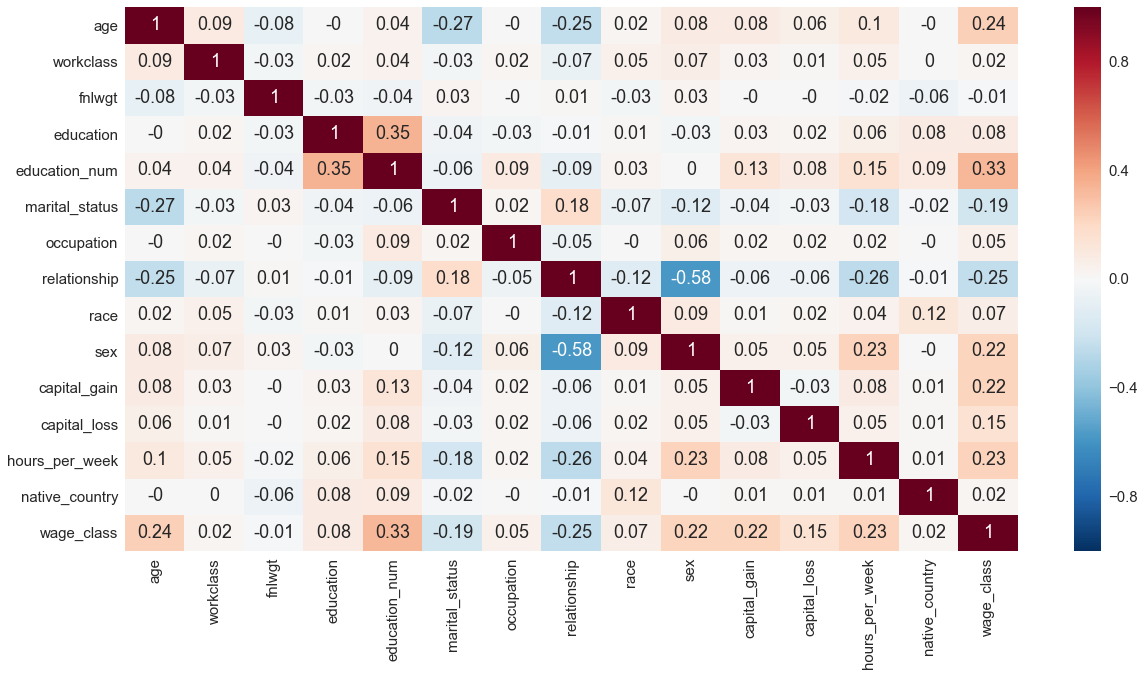

In [288]:
# Analyzing the data correlation
correlation_matrix = dataset.corr().round(2)
# annot = True to print the values inside the square
f, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(data=correlation_matrix, annot=True)

In [297]:
# Ignoring the 'fnlwgt' as it is highly multivariate
# Ignoring 'education' as it is correlated with education_num (higher the number, the higher the education that person has)
# Ignoring 'relationship' as it is Correlated with sex
# Ignoring 'native_country' as 91% of our dataset has their country as United-States
# Keeping the top 5 values with higher correlation
dataset = dataset[['age','education_num','relationship','marital_status','sex','wage_class']]

In [298]:
dataset['wage_class'].unique()

array([0, 1], dtype=int64)

In [299]:
# Setting the train datset after fixing the columns
x_train = dataset[:train_set.shape[0]]

In [300]:
# Setting the train datset after fixing the columns
x_test = dataset[:test_set.shape[0]]

In [301]:
# Setting our target variable
y_train = x_train.pop('wage_class')
y_test = x_test.pop('wage_class')

In [302]:
algorithms = [KNeighborsClassifier(2),DecisionTreeClassifier(),RandomForestClassifier(),LogisticRegression()]
log_train  = pd.DataFrame(columns=["Classifier", "Accuracy"])
log_test  = pd.DataFrame(columns=["Classifier", "Accuracy"])

In [303]:
acc_dict = {}

# Building model using train dataset
for x in algorithms:
    name = x.__class__.__name__
    x.fit(x_train, y_train)
    train_predictions = x.predict(x_train)
    acc = accuracy_score(y_train, train_predictions)
    if name in acc_dict:
        acc_dict[name] += acc
    else:
        acc_dict[name] = acc
print(acc_dict)
for x in acc_dict:
    acc_dict[x] = acc_dict[x] / 10.0
    log_train_entry = pd.DataFrame([[x, acc_dict[x]]], columns=["Classifier", "Accuracy"])
    log_train = log_train.append(log_train_entry)

{'KNeighborsClassifier': 0.79145945229096215, 'DecisionTreeClassifier': 0.84337908626748892, 'RandomForestClassifier': 0.8410251309594855, 'LogisticRegression': 0.7982892381141834}


In [304]:
# Validating our model on the test dataset
for x in algorithms:
    name = x.__class__.__name__
    x.fit(x_test, y_test)
    test_predictions = x.predict(x_test)
    acc = accuracy_score(test_predictions,y_test)
    if name in acc_dict:
        acc_dict[name] += acc
    else:
        acc_dict[name] = acc
print(acc_dict)
for x in acc_dict:
    acc_dict[x] = acc_dict[x] / 10.0
    log_test_entry = pd.DataFrame([[x, acc_dict[x]]], columns=["Classifier", "Accuracy"])
    log_test = log_test.append(log_test_entry)

{'KNeighborsClassifier': 0.8831300089741162, 'DecisionTreeClassifier': 0.93393950225224698, 'RandomForestClassifier': 0.93098166316234954, 'LogisticRegression': 0.87803609512615943}


In [305]:
log_test['Accuracy'] = (log_test['Accuracy']*1000).round(2)
log_test

,Classifier,Accuracy
0,KNeighborsClassifier,88.31
0,DecisionTreeClassifier,93.39
0,RandomForestClassifier,93.10
0,LogisticRegression,87.80


In [306]:
# Trying out XGBoost algorithm

In [308]:
# Tuning on the maximum depth of the trees along with the min_child_weight. 
# Setting the objective to 'binary:logistic' since this is a binary classification problem. 
cv_params = {'max_depth': [3,5,7], 'min_child_weight': [1,3,5]}
ind_params = {'learning_rate': 0.1, 'n_estimators': 1000, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic'}
optimized_GBM = GridSearchCV(xgb.XGBClassifier(**ind_params), 
                            cv_params, 
                             scoring = 'accuracy', cv = 5, n_jobs = -1)

In [309]:
# Fitting our model
optimized_GBM.fit(x_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1000, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.8),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_depth': [3, 5, 7], 'min_child_weight': [1, 3, 5]},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [310]:
# Checking our grid scores
optimized_GBM.grid_scores_

[mean: 0.82186, std: 0.00607, params: {'max_depth': 3, 'min_child_weight': 1},
 mean: 0.82262, std: 0.00610, params: {'max_depth': 3, 'min_child_weight': 3},
 mean: 0.82259, std: 0.00621, params: {'max_depth': 3, 'min_child_weight': 5},
 mean: 0.81742, std: 0.00654, params: {'max_depth': 5, 'min_child_weight': 1},
 mean: 0.81851, std: 0.00593, params: {'max_depth': 5, 'min_child_weight': 3},
 mean: 0.81957, std: 0.00615, params: {'max_depth': 5, 'min_child_weight': 5},
 mean: 0.81175, std: 0.00472, params: {'max_depth': 7, 'min_child_weight': 1},
 mean: 0.81400, std: 0.00506, params: {'max_depth': 7, 'min_child_weight': 3},
 mean: 0.81613, std: 0.00523, params: {'max_depth': 7, 'min_child_weight': 5}]

In [311]:
# To increase the performance of XGBoost's speed through many iterations,we can create a DMatrix. 
# This sorts the data initially to optimize for XGBoost when it builds trees.
xgdmat = xgb.DMatrix(x_train, y_train) 

In [312]:
our_params = {'eta': 0.1, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'max_depth':3, 'min_child_weight':1}

In [313]:
# Grid Search CV optimized settings using dmatrix and early stopping
cv_xgb = xgb.cv(params = our_params, dtrain = xgdmat, num_boost_round = 3000, nfold = 5,metrics = ['error'],early_stopping_rounds = 100)

In [314]:
cv_xgb.tail(5)

,train-error-mean,train-error-std,test-error-mean,test-error-std
133,0.173052,0.001381,0.175199,0.004603
134,0.173052,0.001408,0.175232,0.004558
135,0.173068,0.001389,0.175232,0.004558
136,0.173052,0.001334,0.175199,0.004603
137,0.173085,0.001345,0.175166,0.004535


In [317]:
our_params = {'eta': 0.1, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'max_depth':3, 'min_child_weight':1} 
# Training our model using our parameters on the dmatix 
final_gb = xgb.train(our_params, xgdmat, num_boost_round = 137)

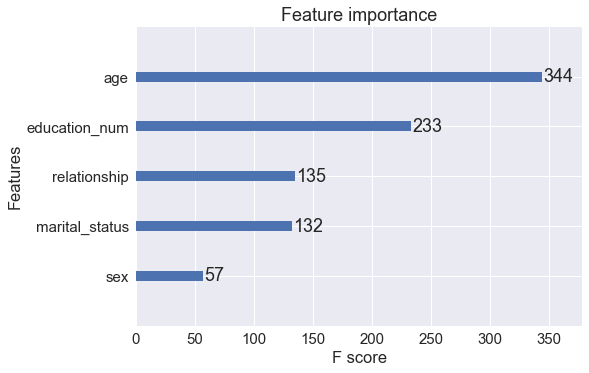

In [318]:
# Plotting the importance of featues which contributes more in deciding the person's income
xgb.plot_importance(final_gb)

In [320]:
# Analyzing our test data
testdmat = xgb.DMatrix(x_test,y_test)

In [324]:
# Grid Search CV optimized settings using dmatrix and early stopping
test_xgb = xgb.cv(params = our_params, dtrain = testdmat, num_boost_round = 3000, nfold = 5,metrics = ['error'],early_stopping_rounds = 100)

In [325]:
test_xgb.tail(5)

,train-error-mean,train-error-std,test-error-mean,test-error-std
87,0.175332,0.001582,0.178553,0.006109
88,0.175282,0.001550,0.178486,0.006181
89,0.175282,0.001520,0.178486,0.006181
90,0.175316,0.001644,0.178486,0.006291
91,0.175365,0.001684,0.178154,0.006033


In [326]:
test_final_gb = xgb.train(our_params, testdmat, num_boost_round = 91)

In [333]:
# Predict using our testdmat
y_pred = test_final_gb.predict(testdmat)
y_pred

array([ 0.25488311,  0.76711458,  0.09154078, ...,  0.73580956,
        0.00695182,  0.36113629], dtype=float32)

In [339]:
# To calculate accuracy we need to convert these to a 0/1 label. We will set 0.5 probability as our threshold.
y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] = 0
y_pred

array([ 0.,  1.,  0., ...,  1.,  0.,  0.], dtype=float32)

In [340]:
accuracy_score(y_pred, y_test), 1-accuracy_score(y_pred, y_test)

(0.82543160690571049, 0.17456839309428951)

In [196]:
print("The accuracy of our model is 83% using XGBoost method")

The accuracy of our model is 83% using XGBoost method


In [341]:
log_test = log_test.append({'Classifier':'XGBoost','Accuracy':'82.54'},ignore_index=True)

In [342]:
log_test

,Classifier,Accuracy
0,KNeighborsClassifier,88.31
1,DecisionTreeClassifier,93.39
2,RandomForestClassifier,93.1
3,LogisticRegression,87.8
4,XGBoost,82.54


In [ ]:
print('Hence from the above analysis KNN,Decisiontree and Randomforest has better efficiency for our problem')